In [44]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [45]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [46]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)
df['real_price'] = df.price
df['price'] = df.price.ewm(span=6, adjust=True).mean()

Text(0, 0.5, 'Price USD ($)')

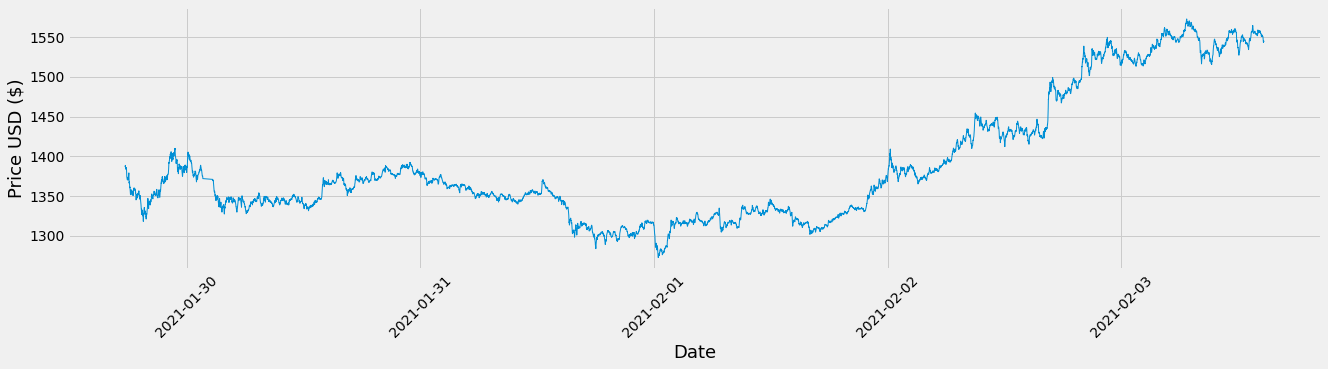

In [47]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
# plt.show()

In [48]:
def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, min_periods=macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 11)
macd_multiplier = 25

df['MACD_buy'], df['Signal Line'] = createMacdAndSignalLines(df.price, macd_params, macd_multiplier)
df['MACD_sell'], _  = createMacdAndSignalLines(df.price, macd_params, macd_multiplier)

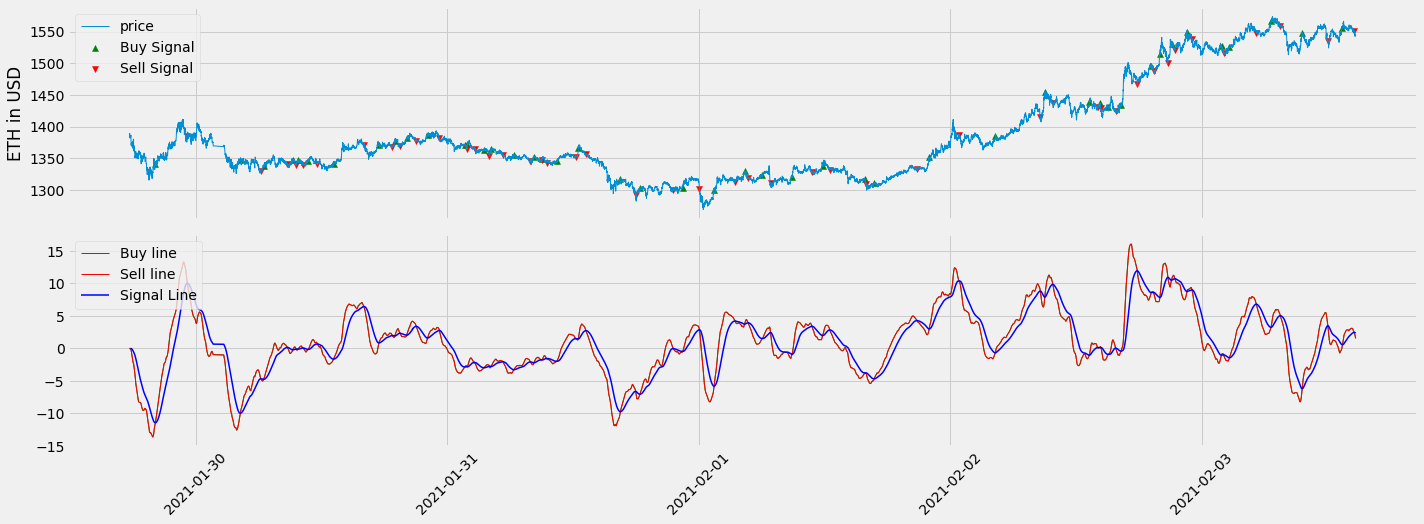

2021-01-29T23:11:15Z Bought at 1345.44. Selling at 1385.06. Profit: +38.61
2021-01-30T06:13:30Z Bought at 1349.69. Selling at 1330.46. Profit: -20.23
2021-01-30T08:44:45Z Bought at 1342.31. Selling at 1340.62. Profit: -2.69
2021-01-30T09:34:15Z Bought at 1352.60. Selling at 1339.77. Profit: -13.82
2021-01-30T10:16:00Z Bought at 1351.43. Selling at 1338.94. Profit: -13.49
2021-01-30T11:36:45Z Bought at 1349.24. Selling at 1340.36. Profit: -9.88
2021-01-30T16:02:00Z Bought at 1337.19. Selling at 1370.38. Profit: +32.18
2021-01-30T18:44:45Z Bought at 1374.78. Selling at 1367.78. Profit: -8.00
2021-01-30T19:29:00Z Bought at 1374.09. Selling at 1370.09. Profit: -5.00
2021-01-30T21:02:00Z Bought at 1377.14. Selling at 1377.49. Profit: -0.65
2021-01-30T23:14:30Z Bought at 1381.98. Selling at 1381.39. Profit: -1.59
2021-01-31T01:52:00Z Bought at 1369.70. Selling at 1365.25. Profit: -5.45
2021-01-31T02:35:45Z Bought at 1376.01. Selling at 1364.94. Profit: -12.07
2021-01-31T04:01:15Z Bought at 1

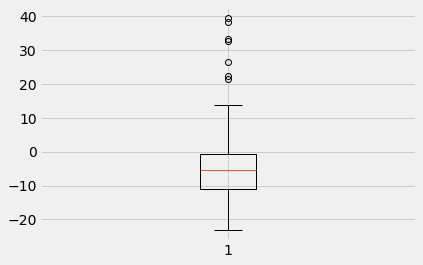

In [49]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(50, len(df)):
        if (bought == False and getBuySignal(df, i)):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if (bought and getSellSignal(df, i)):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], f"Bought at {bought:.2f}. Selling at {df['real_price'].iat[i]:.2f}. Profit: {df['real_price'].iat[i] - bought - 1:+.2f}")
            
            transactions.append(df['real_price'].iat[i] - bought)
            sumwin = sumwin + df['real_price'].iat[i] - bought - 1
            bought = False 
    return(sumwin, transactions)

def getBuySignal(df, i):
  return (df['MACD_buy'].iat[i] > df['Signal Line'].iat[i]) and (df['MACD_buy'].iat[i-1] <= df['Signal Line'].iat[i-1])
def getSellSignal(df, i):
  # return (df["MACD_sell"].diff().iat[i] < 0.05)
  return (df['MACD_sell'].iat[i] < df['Signal Line'].iat[i]) and (df['MACD_sell'].iat[i-1] >= df['Signal Line'].iat[i-1])

#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = 0
  for i in range(0,len(df)):
    #if MACD > signal line  then buy else sell
      if flag != 1 and getBuySignal(df, i):
        sigPriceBuy.append(signal['real_price'][i])
        sigPriceSell.append(np.nan)
        flag = 1
      elif flag != 0 and getSellSignal(df, i): 
        sigPriceSell.append(signal['real_price'][i])
        sigPriceBuy.append(np.nan)
        flag = 0
      else:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

#Create buy and sell columns
df['Buy_Signal_Price'], df['Sell_Signal_Price'] = buy_sell(df)


fig, axs = plt.subplots(2, figsize=(20, 7.5), sharex=True)
plt.xticks(rotation=45)
axs[0].plot( df['real_price'],  label='price', linewidth=1)
axs[0].scatter(df.index, df['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
axs[0].legend(loc='upper left')
axs[0].set_ylabel('ETH in USD')
axs[1].plot(df.index, df['MACD_buy'], label='Buy line', color = 'green', linewidth=1)
axs[1].plot(df.index, df['MACD_sell'], label='Sell line', color = 'red', linewidth=1)
axs[1].plot(df.index, df['Signal Line'], label='Signal Line', color='blue', linewidth=1.5)
axs[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

r = mac_daddy_tester(df)
print("Profit", r[0])
print("Transactions: ", len(r[1]))
plt.boxplot(r[1])
plt.show()

In [50]:
results = []
macd_params = (12, 26, 9)
max_p = -99999
for period_length1 in np.arange(1, 300, 1):
    for period_length2 in np.arange(1, 300, 1):
        df["MACD_buy"], signal = createMacdAndSignalLines(df.price, macd_params, period_length1)
        df["MACD_sell"] = df["MACD_buy"]
        # macd_sell, _ = createMacdAndSignalLines(df.price, macd_params, period_length2)
        r = mac_daddy_tester(df, quiet=True)
        results.append((period_length1, period_length1, r[0], len(r[1])))
        if r[0] > max_p:
            max_p = r[0]
            print("Buy period:", period_length1, "Sell period:", period_length2, "Profit", r[0], "transactions: ", len(r[1]))
    # print(sorted(results, key = lambda x: -x[2]))

Buy period: 1 Sell period: 1 Profit -117.48283399999968 transactions:  46


KeyboardInterrupt: 

In [40]:
# # print(sorted(results, key = lambda x: -x[2]))
# maxi = 0
# for r in results:
#     if r[2] >= maxi:
#         maxi = r[2]
#         print(r)